This example Python script let you access the Granta MI session on our internal virtual machine. You can extract or upload data into the MI databases and perform some data analysis.

In [1]:
# Import libraries
from GRANTA_MIScriptingToolkit import granta as mpy
import GRANTA_MIScriptingToolkit as gdl
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import pandas as pd

In [2]:
session = gdl.GRANTA_MISession('https://academicresearch.grantami.com/mi_servicelayer/', username="Flavia.Papile", password="P455w07d!")
browseService = session.browseService
databases = browseService.GetDatabases().databases

print("Found {0} databases on the Granta MI Server".format(len(databases)))
for d in databases:
    print("Database key: {0.DBKey}, Database name: {0.name}".format(d))

Found 2 databases on the Granta MI Server
Database key: MI_PolimiDB, Database name: MI_PolimiDB
Database key: MI_Training, Database name: MI Training


In [3]:
df = pd.DataFrame({'DBKey': [db.DBKey for db in databases],
                  'DBName': [db.name for db in databases]})
df

,DBKey,DBName
0,MI_PolimiDB,MI_PolimiDB
1,MI_Training,MI Training


In [4]:
# Get Tables from Ref Papers DB
dbKey = "MI_PolimiDB"
tables = browseService.GetTables(gdl.GetTables(DBKey=dbKey)).tableDetails

print("Found {0} tables in database {1}".format(len(tables), dbKey))
for t in tables:
    print("Table name: {0}".format(t.tableReference.name))

Found 2 tables in database MI_PolimiDB
Table name: Material Research Trends
Table name: References


In [8]:
# Get data from Granta ref papers table
table = 'Material Research Trends'
attribute = "Year of development"

tableRef = gdl.PartialTableReference(tableName=table)
attrRef = gdl.AttributeReference(name=attribute, DBKey=dbKey, partialTableReference=tableRef)
searchCriterion = gdl.RecordSearchCriterion(searchAttribute=attrRef, existsSearchValue=gdl.ExistsSearchValue())
request = gdl.CriteriaSearch(DBKey=dbKey, searchCriteria=[searchCriterion])

searchResults = session.searchService.CriteriaSearch(request).searchResults

df2 = pd.DataFrame({'ShortName': [r.shortName for r in searchResults],
                     'LongName': [r.longName  for r in searchResults]})
df2

,ShortName,LongName
0,2006_Responsive structures,2006_Responsive structures
1,2013_Artichair,2013_Artichair
2,2015_Hydromembrane,2015_Hydromembrane
3,2016_Wineleather,2016_Wineleather
4,2017_Nullabor fibre,2017_Nullabor fibre
...,...,...
74,1990_Mater-bi,1990_Mater-bi
75,2002_QTC,2002_QTC
76,2018_Biogarmentry,2018_Biogarmentry
77,2018_This is Grown,2018_This is Grown


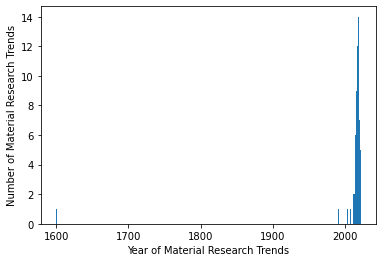

In [9]:
# Year analysis
attribute = "Year of development"
attributeLim = "Labelling"

attributesInt = ["Year of development"]
attrRefs = [gdl.AttributeReference(name=a, DBKey=dbKey, partialTableReference=tableRef) for a in attributesInt]
recordRefs = [r.recordReference for r in searchResults]
request = gdl.GetRecordAttributesByRefRequest(recordReferences=recordRefs, attributeReferences=attrRefs)
recordData = session.dataExportService.GetRecordAttributesByRef(request).recordData

# Export data in a table
s_year = [None]*len(df2)
for attributeInt in attributesInt:
    for idx, record in enumerate(recordData):
        attrValueInt = next((x for x in record.attributeValues if x.attributeName == attributeInt), None)
        s_year[idx] = attrValueInt.integerDataValue.value.real if attrValueInt else None
    df2[attributeInt] = s_year
df2

#Plot
figure=plt.figure(1)
plt.hist(s_year, bins=max(s_year)-min(s_year))
plt.xlabel('Year of Material Research Trends')
plt.ylabel('Number of Material Research Trends')
plt.savefig("MaterialResearchTrends"+".png", bbox_inches='tight')